In [1]:
import glob
import os
import numpy as np
import ast

import polychrom

from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
import polychrom.contactmaps

import cooltools
import cooltools.lib.plotting
from polykit.analysis import contact_maps as cms
import warnings
import h5py 
import matplotlib.pyplot as plt
import cooler

/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


### making dictionary of trajectories

In [2]:
path_dict = {}

# to run this cell, change the directory to simulation folder
directory = '../output/contact_maps/simulations/'
directory = '/scratch1/rahmanin/dynamical_boundary_simulations/simulation_md/simulation_with_pause_mod/simulations_with_hsteps/'
for name  in glob.glob(directory+'sims_o/folder_*'):
    path_dict[name.split('/sims_o/')[1][:]]= name
path_dict = dict(sorted(path_dict.items()))


### creating maps

In [8]:
WT_LIFETIME = 500
monomer_per_replica = 1000 
mapN = 3 * monomer_per_replica #number of monomer for averaging
total_monomers = 10000

# parameters for calculating contact maps
mapstarts = (np.arange(0,8000 , monomer_per_replica))
min_time = 2000 # the number of steps to disregard when calculating contacts (for equilibration purpose)
freq = 1 #frequent frames
res = 10000 #resolution when saving in cooler files
refresh = True
if refresh == True:
    map_dict_eq = {}

for name in list(path_dict.keys())[100:119]:
    new_name = name.split('folder_')[1]
    params = [ast.literal_eval(i) for i in new_name.split('_')[1::2]]
    face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    if slife != WT_LIFETIME: continue
    URIs = polychrom.hdf5_format.list_URIs(path_dict[name])
    URIs_eq = np.array(URIs)[np.array([int(i.split("::")[-1]) for i in URIs]) > min_time][::freq]
    mrc = polychrom.contactmaps.monomerResolutionContactMapSubchains(
        URIs_eq,
        mapstarts,
        mapN,
        cutoff = 2.3,
        n = 8)
    map_dict_eq[name] = mrc
    np.savez_compressed('../output/contact_maps/%s.npz' % new_name, mrc) # to directly save maps in numpy array

    #saving data as .cool files
    cool_uri = ('../output/contact_maps/%s.mcool' % new_name)
    mrc_new = cms.coolify(mrc,
            cool_uri,
            chrom_dict = {},
            binsize = 2500,
            chunksize = 10000000)
    
    clr = cooler.Cooler(cool_uri + '.2500.cool')
    base_uri =cool_uri + '.2500.cool'
    output_uri = cool_uri + '.10000.cool'
    factor = 4
    chunksize = 10000000
    clr_10 = cooler.coarsen_cooler(base_uri, output_uri, factor, chunksize)

### visualizing maps

/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


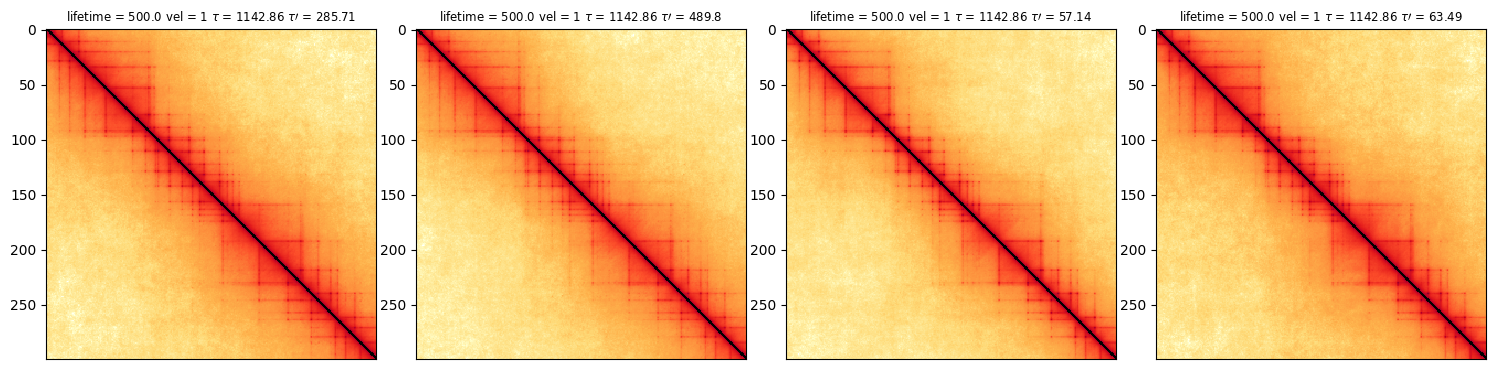

In [4]:
numx,numy = 4, 50
subplot_width = 3.75
plt.figure(figsize = (subplot_width * numx,subplot_width * numy))
c = 0

for name in list(path_dict.keys())[100:119]:
    params = [ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    if slife != WT_LIFETIME: continue
    c += 1
    plt.subplot(numy,numx, c)
    
    # if directly use numpy array for maps
    data=np.load('../output/contact_maps/%s.npz' % name)
    mrc=data['arr_0']
    
    # if using cooler files for visualization
    cool_uri = ('../output/contact_maps/%s.mcool'%name)
    region = 'chr_sim:0-7500000' # determining the region to visualize
    mrcn = (cooler.Cooler(cool_uri + '.10000.cool').matrix(balance = False).fetch(region))
    mrc  = mrcn.astype(float)
    mrc  = mrc.astype(float)
    mrc /= np.median(np.diag(mrc,2))
    mat = np.log10(mrc)

    vmax = np.median(np.diag(mat,2))
    vmin = vmax - 3
    plt.matshow(mat[:300,:300], cmap='fall', fignum=False);
    plt.title(r'lifetime = %s vel = %s $\tau$ = %s $\tau\prime$ = %s'%(life, vel, clife, cof), fontsize =8.5)
    plt.xticks([])
plt.tight_layout()
plt.show()